## Imports

In [1]:
import os
import time
import config
from dataset import LyftDataset

import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as T

from DSRL.modeling.deeplab import DeepLab
from DSRL.utils.fa_loss import FALoss
from DSRL.utils.metrics import Evaluator

/home/freyr/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Model

In [2]:
model = DeepLab(num_classes=13)

## Dataset and DataLoaders

In [3]:
train_ds = LyftDataset(sect="B", split="train")
val_ds = LyftDataset(sect="B", split="val")
# test_ds = LyftDataset(sect="B", split="test")

In [4]:
train_dl = DataLoader(train_ds, config.BATCH_SIZE, shuffle=True, 
                      pin_memory=config.PIN_MEMORY, 
                      num_workers=config.NUM_WORKERS)

val_dl = DataLoader(val_ds, config.BATCH_SIZE, shuffle=False, 
                      pin_memory=config.PIN_MEMORY, 
                      num_workers=config.NUM_WORKERS)

## Training

In [5]:
w_sr, w_fa = 0.5, 0.5
model = model.to(config.DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR, betas=config.BETAS)

In [8]:
from tqdm.auto import tqdm

def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0
    
    print("Training Phase ...")
    pbar = tqdm(range(len(train_dataloader)))
    for image, labels in train_dataloader:
        image = image.to(config.DEVICE)
        labels = labels.to(torch.float)
        labels = labels.to(config.DEVICE)
        input_img=torch.nn.functional.interpolate(image, size=[i//2 for i in image.size()[2:]], mode='bilinear', align_corners=True)

        optimizer.zero_grad()
        output, output_sr, fea_seg, fea_sr = model(input_img)

        loss = loss_fn(output, labels)+ w_sr*torch.nn.MSELoss()(output_sr,image)+w_fa*FALoss()(fea_seg,fea_sr)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        pbar.update()

    return losses / len(train_ds)

def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    evaluator = Evaluator(config.NUM_CLASSES)
    print("Validation Phase ...")
    qbar = tqdm(range(len(val_dataloader)))
    for image, labels in val_dataloader:
        input_img=torch.nn.functional.interpolate(image,size=[i//2 for i in image.size()[2:]], mode='bilinear', align_corners=True)
        labels = labels.to(torch.float)
        input_img, image, labels = input_img.to(config.DEVICE), image.to(config.DEVICE), labels.to(config.DEVICE)
        with torch.no_grad():
            output,_,_,_ = model(input_img)

        loss = loss_fn(output, labels)
        losses += loss.item()
        qbar.update()
        pred = output.data.cpu().numpy()
        labels = labels.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(np.argmax(labels, axis=1), pred)
    
    mIoU = evaluator.Mean_Intersection_over_Union()

    return losses / len(val_ds), mIoU

In [9]:
from timeit import default_timer as timer
import warnings
warnings.filterwarnings('ignore')
NUM_EPOCHS = 10

history = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_dl)
    end_time = timer()
    val_loss, mIoU = evaluate(model, val_dl)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, mIoU: {mIoU}, Epoch time = {(end_time - start_time):.3f}s"))
    
    history.append({"Epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "epoch_time": (end_time - start_time), "mIoU": mIoU})

Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.038, Val loss: 0.028, mIoU: 0.3317370472590306, Epoch time = 58.406s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.031, Val loss: 0.032, mIoU: 0.3314002700852447, Epoch time = 59.892s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.031, Val loss: 0.030, mIoU: 0.33256619014408817, Epoch time = 61.167s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.029, Val loss: 0.023, mIoU: 0.35318751865317716, Epoch time = 66.968s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.028, Val loss: 0.023, mIoU: 0.3600823879285736, Epoch time = 58.818s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.024, Val loss: 0.019, mIoU: 0.38097612043931944, Epoch time = 58.944s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.023, Val loss: 0.018, mIoU: 0.3932076805268191, Epoch time = 59.193s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.022, Val loss: 0.018, mIoU: 0.40053290888952703, Epoch time = 58.937s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.021, Val loss: 0.020, mIoU: 0.39804312556733035, Epoch time = 59.365s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.021, Val loss: 0.018, mIoU: 0.4021239066531834, Epoch time = 58.559s


In [10]:
torch.save(model, 'models/dsrl-lyft.pth')

## Results and Analysis

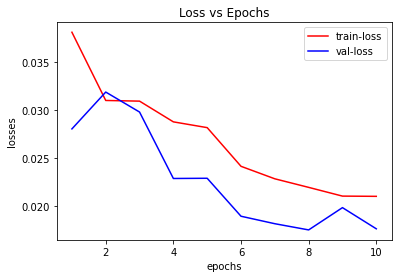

In [11]:
import matplotlib.pyplot as plt

train_losses = [item['train_loss'] for item in history]
val_losses = [item['val_loss'] for item in history]
epochs =  list(range(1, 11))

plt.plot(epochs, train_losses, color='r')
plt.plot(epochs, val_losses, color='b')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(['train-loss', 'val-loss'])

plt.title('Loss vs Epochs')
plt.savefig('LossPlot.png')
plt.show()

## Testing Our Changes

In [12]:
from DSRL.modeling.deeplabs2 import DeepLab

In [13]:
model = DeepLab(num_classes=13)

In [14]:
w_sr, w_fa = 0.5, 0.5
model = model.to(config.DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR, betas=config.BETAS)

In [16]:
NUM_EPOCHS = 10

history2 = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_dl)
    end_time = timer()
    val_loss, mIoU = evaluate(model, val_dl)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, mIoU: {mIoU}, Epoch time = {(end_time - start_time):.3f}s"))
    
    history2.append({"Epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "epoch_time": (end_time - start_time), "mIoU": mIoU})

Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.043, Val loss: 0.067, mIoU: 0.28153973872955607, Epoch time = 57.296s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.034, Val loss: 0.037, mIoU: 0.3188405835236232, Epoch time = 57.367s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.030, Val loss: 0.045, mIoU: 0.3401324618735735, Epoch time = 58.440s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.027, Val loss: 0.021, mIoU: 0.3617928489314075, Epoch time = 57.253s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.026, Val loss: 0.021, mIoU: 0.36848125228129164, Epoch time = 58.309s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.024, Val loss: 0.019, mIoU: 0.3870327169503497, Epoch time = 57.966s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.023, Val loss: 0.072, mIoU: 0.3729340542432483, Epoch time = 59.077s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.021, Val loss: 0.017, mIoU: 0.4070400291176087, Epoch time = 58.186s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.023, Val loss: 0.023, mIoU: 0.3971251222607905, Epoch time = 58.714s
Training Phase ...


  0%|          | 0/50 [00:00<?, ?it/s]

Validation Phase ...


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.022, Val loss: 0.025, mIoU: 0.39490295539164016, Epoch time = 59.058s


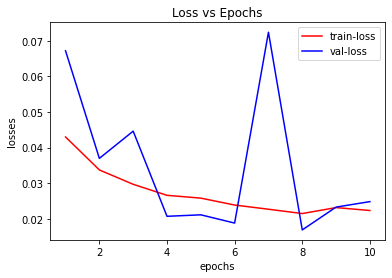

In [17]:
import matplotlib.pyplot as plt

train_losses = [item['train_loss'] for item in history2]
val_losses = [item['val_loss'] for item in history2]
epochs =  list(range(1, 11))

plt.plot(epochs, train_losses, color='r')
plt.plot(epochs, val_losses, color='b')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(['train-loss', 'val-loss'])

plt.title('Loss vs Epochs')
plt.savefig('LossPlot2.png')
plt.show()

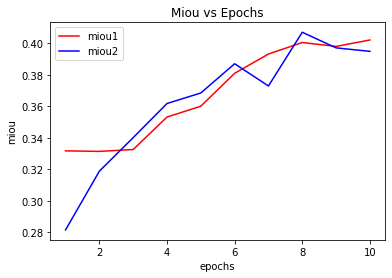

In [19]:
miou1 = [item['mIoU'] for item in history]
miou2 = [item['mIoU'] for item in history2]

plt.plot(epochs, miou1, color='r')
plt.plot(epochs, miou2, color='b')

plt.xlabel('epochs')
plt.ylabel('miou')
plt.legend(['miou1', 'miou2'])

plt.title('Miou vs Epochs')
plt.savefig('miou.png')
plt.show()

In [20]:
torch.save(model, 'models/dsrl2-seg.pth')

## Inferencing

In [1]:
try:
    import random
    i = torch.randn((1, 3, 128, 128))
    o = model(i.cuda())
except:
    import time
    import torch
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    from dataset import LyftDataset

    model = torch.load('models/dsrl-lyft.pth')

/home/freyr/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
test_ds = LyftDataset(split="test")

In [3]:
def infer_pt(fname, index=-1, cls_idx=7):
    """Inference for Pytorch"""
    if index == -1:
        index = random.randint(0, len(test_ds))
        
    sample = test_ds[index][0]
    
    start = time.perf_counter()
    inp = sample.unsqueeze(0).cuda()
    out, out_sr, _, _ = model(inp)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(sample.cpu().permute(1, 2, 0))
    ax[1].imshow(out.squeeze(0).cpu().detach().permute(1, 2, 0)[..., cls_idx])
    end = time.perf_counter()
    print(f"Inference done in time: {end-start:.3f}s")
    plt.savefig('results/'+fname)
    plt.show()

/home/freyr/dev/academics/Computer Vision/Project/dataset.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Inference done in time: 0.204s


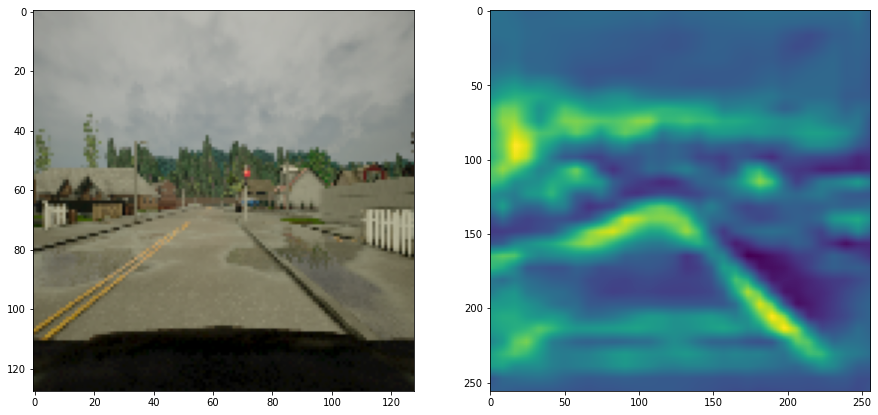

In [4]:
infer_pt('infer11.png')

Inference done in time: 0.170s


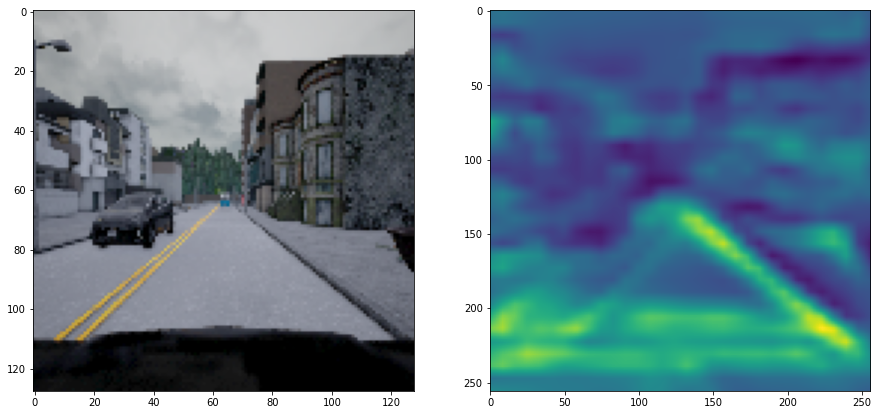

In [6]:
infer_pt('infer22.png')

## DUMP

In [3]:
from dataset import LyftDataset
import cv2 as cv

ds = LyftDataset(split='full')

In [11]:
img = torch.as_tensor(cv.resize(cv.imread('data/lyft/dataA/dataA/CameraRGB/05_00_041.png'), (128, 128)))
mask = cv.cvtColor(cv.imread('data/lyft/dataA/dataA/CameraSeg/05_00_041.png'), cv.COLOR_BGR2RGB)
        
masks = []
for i in range(13):
    cls_mask = np.where(mask == i, 255, 0)
    cls_mask = cls_mask.astype('float')
    cls_mask = cv.resize(cls_mask, (128, 128))

    masks.append(cls_mask[:,:,0] / 255)
    
masks = torch.as_tensor(masks, dtype=torch.uint8)    

/tmp/ipykernel_599/1379245226.py:12: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


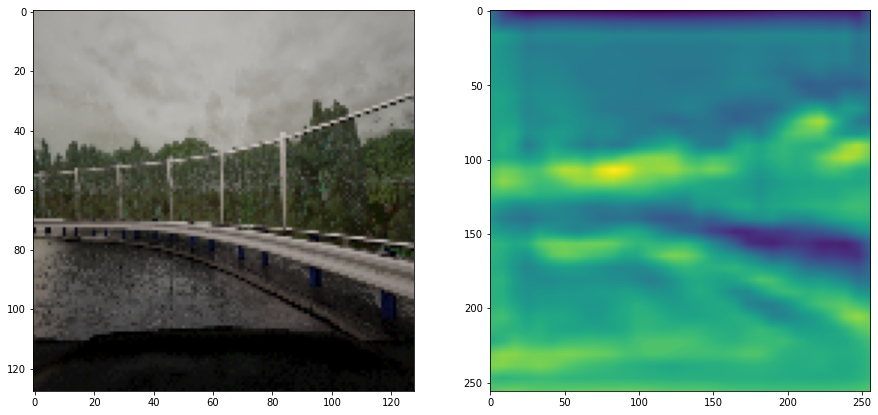

In [12]:
inp = img.permute(2, 0, 1).unsqueeze(0).to(torch.float).cuda()
out, out_sr, _, _ = model(inp)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.cpu())
ax[1].imshow(out.squeeze(0).cpu().detach().permute(1, 2, 0)[..., 7])
end = time.perf_counter()

plt.savefig('results/'+'ogg0.png')
plt.show()

In [ ]:
img = torch.as_tensor(cv.resize(cv.imread('data/lyft/dataA/dataA/CameraRGB/03_01_150.png'), (128, 128)))
mask = cv.cvtColor(cv.imread('data/lyft/dataA/dataA/CameraSeg/05_00_041.png'), cv.COLOR_BGR2RGB)

inp = img.permute(2, 0, 1).unsqueeze(0).to(torch.float).cuda()
out, out_sr, _, _ = model(inp)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.cpu())
ax[1].imshow(out.squeeze(0).cpu().detach().permute(1, 2, 0)[..., 7])
end = time.perf_counter()

plt.savefig('results/'+'ogg0.png')
plt.show()

(600, 800, 3) (600, 800, 3)


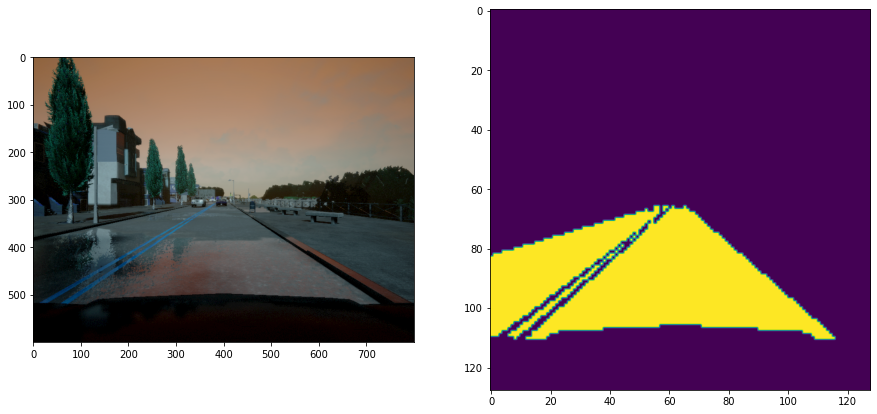

In [19]:
import matplotlib.pyplot as plt

print(img.shape, mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img)
ax[1].imshow(masks.permute(1, 2, 0)[..., 7])
plt.show()